[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/classical_ml/random_forest.ipynb)

Scaling is not necessary for random forests

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.model_selection import FeatureImportances

pd.set_option('mode.chained_assignment', None)

In [3]:
df = pd.read_csv('data.csv')
print(f"initial df rows: {df.shape[0]}")
df.dropna(inplace=True)
df.columns[df.isna().any()].tolist()
df['image_index'] = df['image_index'].astype(int)

initial df rows: 59339670


In [4]:
df.head()

,todays_frp_0,todays_frp_1,todays_frp_2,todays_frp_3,todays_frp_4,todays_frp_5,todays_frp_6,todays_frp_7,todays_frp_8,elevation_0,...,todays_fires_1,todays_fires_2,todays_fires_3,todays_fires_4,todays_fires_5,todays_fires_6,todays_fires_7,todays_fires_8,tomorrows_fires,image_index
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.457222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.195850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.999035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.430490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.173134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Train/test/val split in seperate csv

In [5]:
splits_df = pd.read_csv('splits.csv')

splits_df.head()

,sample_id,class
0,0,train
1,1,train
2,2,train
3,3,train
4,4,train


In [6]:
np.nan

nan

In [7]:
splits_df['class'].unique()

array(['train', 'test', 'eval', nan], dtype=object)

In [8]:
df['image_index'].nunique()

15435

In [9]:
splits_df['sample_id'].nunique()

15435

In [10]:
splits_df['class'].value_counts()

train    10257
eval      1498
test      1280
Name: class, dtype: int64

In [11]:
def get_test_train_val(df: pd.DataFrame) -> tuple:
    """
    Returns a tuple of train, test, validation dataframes.
    """
    train = df[df['class'] == 'train']['sample_id'].values
    test = df[df['class'] == 'test']['sample_id'].values
    val = df[df['class'] == 'eval']['sample_id'].values
    return train, test, val


train_indexes, test_indexes, val_indexes = get_test_train_val(splits_df)

Split the dataset to ensure features from a single image are not split into train & validation - keep the final 20% images for test

In [12]:
train_df = df[df['image_index'].isin(train_indexes)]
test_df = df[df['image_index'].isin(test_indexes)]
val_df = df[df['image_index'].isin(val_indexes)]

In [13]:
train_df = train_df.sample(frac=0.1, random_state=42) # downsample to 10% of the original data

Verify no overlap

In [14]:
set(train_df['image_index'].unique()).intersection(set(test_df['image_index'].unique()))

set()

In [15]:
def get_features(df: pd.DataFrame) -> tuple:
    """convenience to return features and labels"""
    try:
        df = df.drop(columns='image_index')
    except:
        pass # already dropped
    features_df = df.loc[:, df.columns != 'tomorrows_fires']
    features = features_df.values
    feature_names = list(features_df.columns)
    targets = df['tomorrows_fires'].values
    return features, targets, feature_names

X_train, y_train, feature_names = get_features(train_df)
X_test, y_test, _ = get_features(test_df)

In [16]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(3942791, 36)
(3942791,)
(4920320, 36)
(4920320,)


## Naive baseline
What we expect if we simply use the previous fire mask as prediction

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98   4750809
         1.0       0.37      0.37      0.37    169511

    accuracy                           0.96   4920320
   macro avg       0.67      0.67      0.67   4920320
weighted avg       0.96      0.96      0.96   4920320

predicted 172259 fires but true value 169511, ratio 1.0162113373173423
Confusion matrix:
[[4641481  109328]
 [ 106580   62931]]


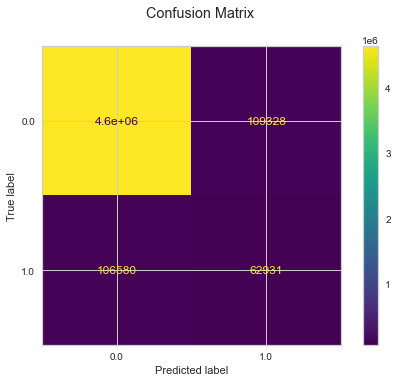

In [17]:
# Naive baseline
todays_fires_index = feature_names.index('todays_fires_4')
test_todays_fires = X_test[:, todays_fires_index].copy()
print(f"{metrics.classification_report(y_test, test_todays_fires)}")

fires_predicted = int(test_todays_fires.sum())
true_fires = int(y_test.sum())
print(f"predicted {fires_predicted} fires but true value {true_fires}, ratio {fires_predicted/true_fires}" )

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, test_todays_fires)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()


## Model training

Sweep Fire weight

| Fire weight  | max_depth   | fire precision  | fire recall | no-fire precision  | no-fire recall |
| -----------  | ----------- | -----------     | ----------- | -----------        |    ----------- |
| Baseline     | NA          |      0.37       |    0.37     |      0.98          |     0.98       |
| 2            | 6           |      0.52       |    0.14     |      0.97          |     1.00       |
| 3.25         | 6           |      0.43       |    0.33     |      0.98          |     0.98       |
| 4            | 6           |      0.40       |    0.40     |      0.98          |     0.98       |
| 4.5          | 6           |      0.38       |    0.43     |      0.98          |     0.98       |
| 5            | 6           |      0.37       |    0.45     |      0.98          |     0.97       |


Sweep max_depth

| Fire weight  | max_depth   | fire precision  | fire recall | no-fire precision  | no-fire recall |
| -----------  | ----------- | -----------     | ----------- | -----------        |    ----------- |
| Baseline     | NA          |      0.37       |    0.37     |      0.98          |     0.98       |
| 3.25         | 6           |      0.43       |    0.33     |      0.98          |     0.98       |
| 3.25         | 10          |      0.44       |    0.34     |      0.98          |     0.98       |
| 3.25         | 15          |      0.48       |    0.28     |      0.97          |     0.99       |
| 4            | 5           |      0.38       |    0.39     |      0.98          |     0.98       |
| 4            | 6           |      0.40       |    0.40     |      0.98          |     0.98       |
| 4            | 7           |      0.40       |    0.40     |      0.98          |     0.98       |
| 4            | 8           |      0.41       |    0.41     |      0.98          |     0.98       |
| 4            | 9           |      0.41       |    0.41     |      0.98          |     0.98       |
| 4            | 10          |      0.41       |    0.41     |      0.98          |     0.98       |
| 4            | 12          |      0.42       |    0.39     |      0.98          |     0.98       |


Best result

| Fire weight  | max_depth   | fire precision  | fire recall | no-fire precision  | no-fire recall |
| -----------  | ----------- | -----------     | ----------- | -----------        |    ----------- |
| 4            | 10           |      0.41       |    0.41     |      0.98          |     0.98       |

In [19]:
%%time
CLASS_WEIGHT = {0:1.0, 1:4}
model = RandomForestClassifier(n_estimators = 100, n_jobs=-1, max_depth=10, class_weight=CLASS_WEIGHT) #  

# Learn the digits on the train subset
model.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = model.predict(X_test)
print(f"{metrics.classification_report(y_test, predicted)}")

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98   4750809
         1.0       0.41      0.41      0.41    169511

    accuracy                           0.96   4920320
   macro avg       0.69      0.69      0.69   4920320
weighted avg       0.96      0.96      0.96   4920320

CPU times: user 21min 39s, sys: 14.4 s, total: 21min 53s
Wall time: 3min 26s


predicted 169089.0 fires but true value 169511.0, ratio 0.998
Confusion matrix:
[[4650724  100085]
 [ 100507   69004]]


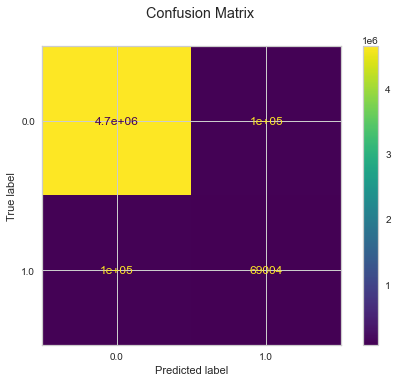

In [20]:
## confustion matrix
fires_predicted = model.predict(X_test).sum()
true_fires = y_test.sum()
print(f"predicted {fires_predicted} fires but true value {true_fires}, ratio {round(fires_predicted/true_fires, 3)}" )

disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

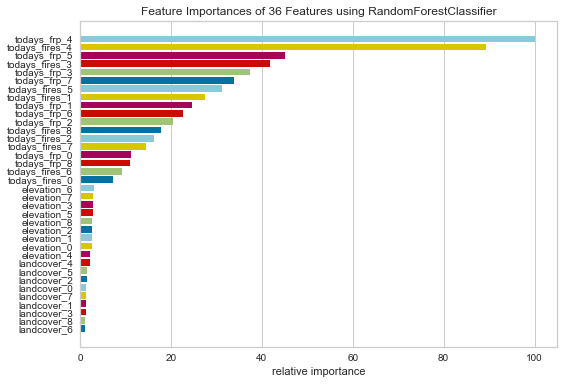

<AxesSubplot:title={'center':'Feature Importances of 36 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [ ]:
viz = FeatureImportances(model, labels=feature_names)
viz.fit(X_train, y_train)
viz.show()

## Viz predictions

In [ ]:
df = pd.read_csv('data.csv')

df.head()

We have the images indexed

In [21]:
img_indexes = test_df['image_index'].unique()

img_indexes[:5]

array([1155, 1157, 1158, 1159, 1160])

In [22]:
def plot_fire(img_index: int):
    df_img = df[df['image_index'] == img_index]
    df_img.drop(columns='image_index', inplace=True)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 25))
    ax1.imshow(df_img['todays_fires_4'].values.reshape(62,62), cmap='inferno')
    ax1.set_title('Todays fires')

    tomorrows_fires = df_img['tomorrows_fires'].values.reshape(62,62)
    ax2.imshow(tomorrows_fires, cmap='inferno')
    ax2.set_title('Tomorrows fires (actual)')

    features = df_img.loc[:, df_img.columns != 'tomorrows_fires'].values
    fires_predicted = model.predict(features).reshape(62,62)
    ax3.imshow(fires_predicted, cmap='inferno')
    ax3.set_title('Predicted fires')
    
    fire_union = np.logical_and(tomorrows_fires, fires_predicted)
    ax4.imshow(fire_union, cmap='inferno')
    ax4.set_title('Correctly predicted fire pixels')

    fire_error =  np.abs(fires_predicted - tomorrows_fires)
    ax5.imshow(fire_error, cmap='inferno')
    ax5.set_title('Error fire pixels')

1155


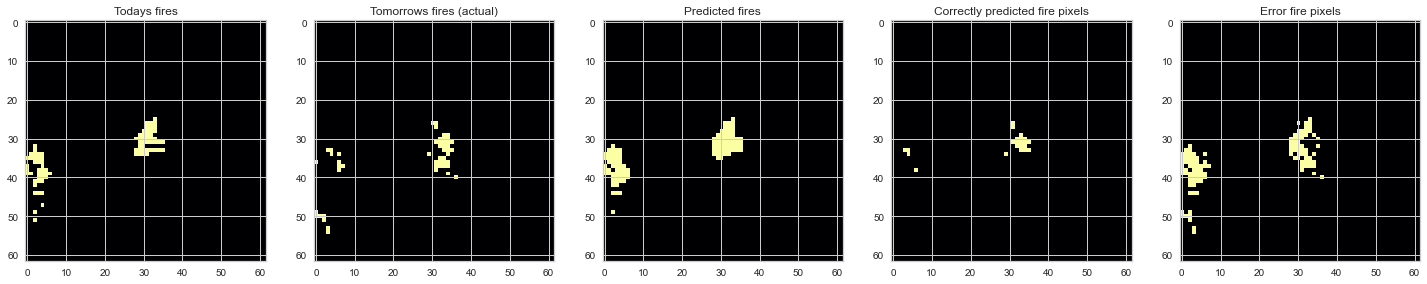

In [23]:
img_index = img_indexes[0]
print(int(img_index))
plot_fire(img_index)